In [33]:
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print("Setup Complete")

Setup Complete


# Introduction
We're going to be predicting the Federal Reserve's interest rate hike decisions based on the inflation rate of the US. CPI data was taken from the St. Louis Fed website and interest rate data was taken from the New York Fed website.

The inflation figures are seasonally-adjusted monthly percent changes. The interest rate data is the target rate range (low and high) for interest rates.

In [34]:
df_inf = pd.read_csv('Inflation.csv')
df_inf.head()

,DATE,CPIAUCSL_PCH
0,1947-02-01,0.65177
1,1947-03-01,1.75763
2,1947-04-01,0.00000
3,1947-05-01,-0.22727
4,1947-06-01,0.59226


In [35]:
df_int = pd.read_csv('Interest.csv')
df_int.head()

,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
0,09/25/2023,EFFR,5.33,5.3,5.32,5.34,5.55,93.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09/22/2023,EFFR,5.33,5.3,5.32,5.34,5.55,94.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09/21/2023,EFFR,5.33,5.3,5.32,5.34,5.55,87.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,09/20/2023,EFFR,5.33,5.3,5.32,5.34,5.55,89.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,09/19/2023,EFFR,5.33,5.3,5.32,5.34,5.55,90.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
## Dropping and Renaming
### Interest Data
First, let's drop useless columns from the interest dataset. We only care about the upper and lower bound columns, since those were implemeneted right after the 2008 financial crisis ended. I don't want to handle the data before 2008, since the Fed's strategy was different back then.

In [36]:
df_int = df_int[['Effective Date', 'Target Rate From (%)', 'Target Rate To (%)']]
df_int = df_int.rename(columns={'Effective Date': 'Date', 'Target Rate From (%)': 'Lower',
                                'Target Rate To (%)': 'Upper'})
df_int = df_int.dropna()
df_int.head()

,Date,Lower,Upper
0,09/25/2023,5.25,5.5
1,09/22/2023,5.25,5.5
2,09/21/2023,5.25,5.5
3,09/20/2023,5.25,5.5
4,09/19/2023,5.25,5.5


### Inflation Data
Now, we'll do the same for inflation data. We'll mainly just rename the columns here to make them faster to type out.

In [37]:
df_inf = df_inf.rename(columns={'DATE': 'Date', 'CPIAUCSL_PCH': 'CPI'})

## Date Alignment
Let's see how far back each dataset goes.

In [38]:
df_inf['Date'] = pd.to_datetime(df_inf['Date'])
df_int['Date'] = pd.to_datetime(df_int['Date'])
print('Inflation: ', df_inf['Date'].min())
print('Interest: ', df_int['Date'].min())

Inflation:  1947-02-01 00:00:00
Interest:  2008-12-16 00:00:00


Interest data only goes back to 2008, which was the 2008 financial crisis. Let's drop all inflation data before 2008.

In [39]:
df_inf = df_inf[df_inf['Date'] >= '2008-12-16']
print('Inflation: ', df_inf['Date'].min())
print('Interest: ', df_int['Date'].min())

Inflation:  2009-01-01 00:00:00
Interest:  2008-12-16 00:00:00


The dates aren't aligned still, but that's fine. We can align them ourselves. First, let's verify that the inflation rate data is always monthly.

In [40]:
df_inf['Date'].diff().value_counts()


Date
31 days    102
30 days     58
28 days     12
29 days      3
Name: count, dtype: int64

This looks about right, since there are 28-31 days in a month. We will now align the dates.

### Data Binning
First, we will group the interest data by month. Each bin will be the average of all the values in that month. Usually, intra-month changes aren't that major because the Fed makes changes every several months. Then, we will merge the two datasets on the date column.

In [41]:
df_int = df_int.groupby(pd.Grouper(key='Date', freq='M')).mean().reset_index()
df_int.head()

,Date,Lower,Upper
0,2008-12-31,0.0,0.25
1,2009-01-31,0.0,0.25
2,2009-02-28,0.0,0.25
3,2009-03-31,0.0,0.25
4,2009-04-30,0.0,0.25


In [42]:
df_inf = df_inf.groupby(pd.Grouper(key='Date', freq='M')).mean().reset_index()
df_inf.head()

,Date,CPI
0,2009-01-31,0.25308
1,2009-02-28,0.36427
2,2009-03-31,-0.09873
3,2009-04-30,0.10071
4,2009-05-31,0.14715


In [43]:
df_inf['Date'] = df_inf['Date'].dt.strftime('%Y-%m')
df_int['Date'] = df_int['Date'].dt.strftime('%Y-%m')
df_int.head()

,Date,Lower,Upper
0,2008-12,0.0,0.25
1,2009-01,0.0,0.25
2,2009-02,0.0,0.25
3,2009-03,0.0,0.25
4,2009-04,0.0,0.25


In [44]:
df = pd.merge(df_inf, df_int, on='Date')
df.head()

,Date,CPI,Lower,Upper
0,2009-01,0.25308,0.0,0.25
1,2009-02,0.36427,0.0,0.25
2,2009-03,-0.09873,0.0,0.25
3,2009-04,0.10071,0.0,0.25
4,2009-05,0.14715,0.0,0.25


Now, we'll split year and month into separate columns to make processing easier.

In [45]:
df.insert(0, 'Year', df['Date'].str.split('-').str[0])
df.insert(1, 'Month', df['Date'].str.split('-').str[1])
df = df.drop('Date', axis=1)
df.head()


,Year,Month,CPI,Lower,Upper
0,2009,01,0.25308,0.0,0.25
1,2009,02,0.36427,0.0,0.25
2,2009,03,-0.09873,0.0,0.25
3,2009,04,0.10071,0.0,0.25
4,2009,05,0.14715,0.0,0.25


In [46]:
df['Year'].value_counts()


Year
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023     8
Name: count, dtype: int64

Good! It looks like each year has exactly 12 months of data, meaning it's evenly spaced. There's the exception of 2023, since that's the current year and it hasn't ended yet.

# Data Analysis & Feature Engineering

## Correlation and Interest Regimes
Let's see how correlated CPI is with the upper and lower bound of interest rates.

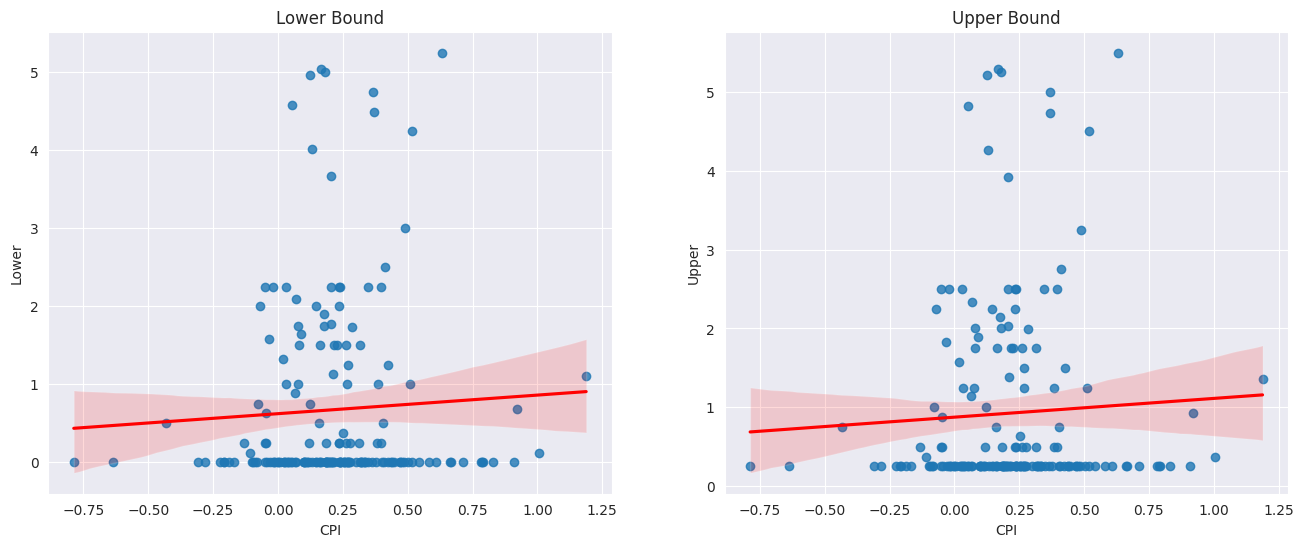

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.regplot(x=df['CPI'], y=df['Lower'], line_kws={'color': 'red'})
plt.title('Lower Bound')
plt.subplot(122)
sns.regplot(x=df['CPI'], y=df['Upper'], line_kws={'color': 'red'})
plt.title('Upper Bound')
plt.show()


It looks like they aren't that correlated, likely due to the Fed keeping interest rates constantly low after the 2008 financial crisis. Let's determine when this period of low rates stopped.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

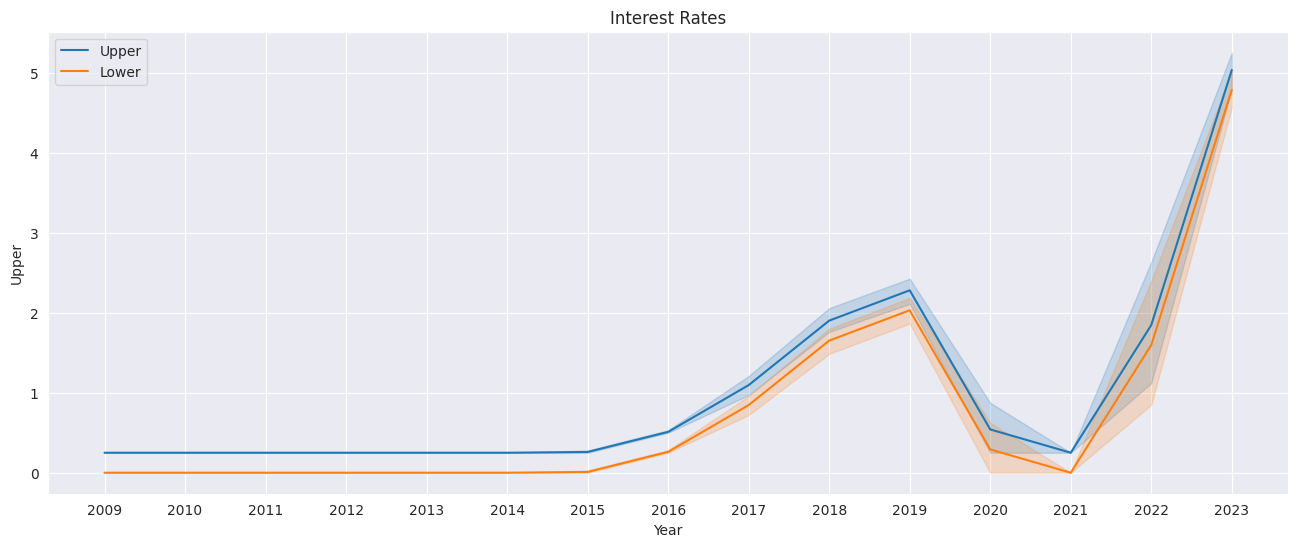

In [48]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=df['Year'], y=df['Upper'], label='Upper')
sns.lineplot(x=df['Year'], y=df['Lower'], label='Lower')
plt.title('Interest Rates')
plt.legend()
plt.show()

It seems that they briefly went up during the 2015-2020 period, before dropping to near-zero to the COVID-19 pandemic. It increased in 2015 because the Fed thought the economy would remain strong. Lastly, starting in 2021, the Fed began aggressively increasing rates to combat inflation. We will categorize these 4 distinct "regimes" with 1 new column. We use ordinal instead of one-hot encoding because the regimes are ordered chronologically.

In [49]:
df['Regime'] = 0
df['Regime'].loc[df['Year'] >= '2015'] = 1
df['Regime'].loc[df['Year'] >= '2020'] = 2
df['Regime'].loc[df['Year'] >= '2021'] = 3
df.head()

/tmp/ipykernel_1057/3867219362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Regime'].loc[df['Year'] >= '2015'] = 1
/tmp/ipykernel_1057/3867219362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Regime'].loc[df['Year'] >= '2020'] = 2
/tmp/ipykernel_1057/3867219362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Regime'].loc[df['Year'] >= '2021'] = 3


,Year,Month,CPI,Lower,Upper,Regime
0,2009,01,0.25308,0.0,0.25,0
1,2009,02,0.36427,0.0,0.25,0
2,2009,03,-0.09873,0.0,0.25,0
3,2009,04,0.10071,0.0,0.25,0
4,2009,05,0.14715,0.0,0.25,0


## Autocorrelation
It's important to account for any seasonalities/trends in the data. Let's use the ACF (autocorrelation function) and PACF (partial autocorrelation function) graphs to see how dependent our target variable specifically is on time.

<Figure size 1600x600 with 0 Axes>

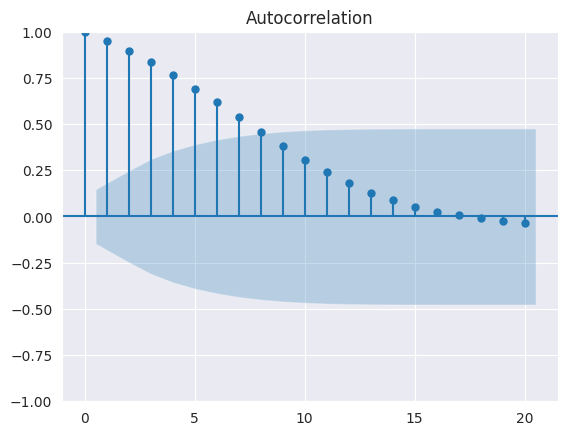

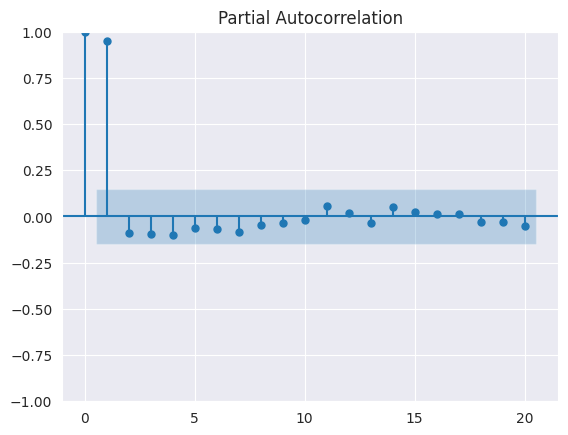

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16, 6))
plot_acf(df['Upper'], lags=20)
plot_pacf(df['Upper'], lags=20)
plt.show()

According to the PACF graph, the first lag is very significant. According to the ACF graph, autocorrelation stops after 15 lags.

## Lag Features
Let's add lag features (they're very important for time-series data).

In [51]:
for i in range(15, 0, -1):
    df[f'Upper Lag - {i}'] = df['Upper'].shift(i)
    df[f'Lower Lag - {i}'] = df['Lower'].shift(i)
    df[f'Regime Lag - {i}'] = df['Regime'].shift(i)
    df[f'CPI Lag - {i}'] = df['CPI'].shift(i)
df = df.dropna()
df.head()

,Year,Month,CPI,Lower,Upper,Regime,Upper Lag - 1,Lower Lag - 1,Regime Lag - 1,CPI Lag - 1
1,2009,02,0.36427,0.0,0.25,0,0.25,0.0,0.0,0.25308
2,2009,03,-0.09873,0.0,0.25,0,0.25,0.0,0.0,0.36427
3,2009,04,0.10071,0.0,0.25,0,0.25,0.0,0.0,-0.09873
4,2009,05,0.14715,0.0,0.25,0,0.25,0.0,0.0,0.10071
5,2009,06,0.82996,0.0,0.25,0,0.25,0.0,0.0,0.14715


## Scaling Values
For LSTM, we need to scale the values. It's better to use StandardScaler if the data follows a normal distribution. Let's check for that first.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

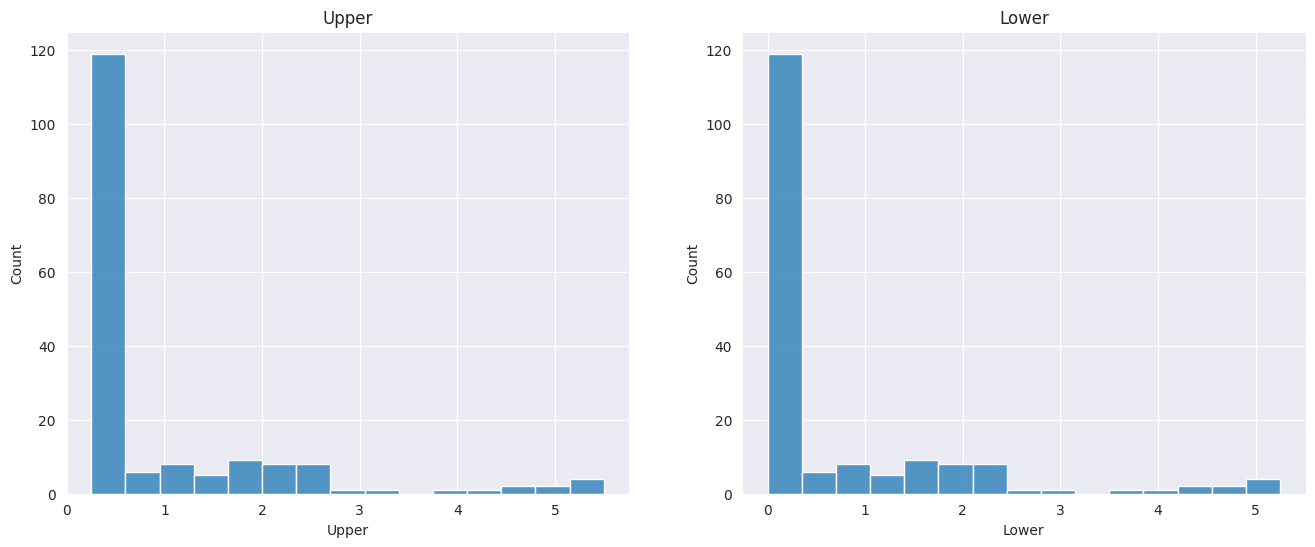

In [52]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.histplot(df['Upper'])
plt.title('Upper')
plt.subplot(122)
sns.histplot(df['Lower'])
plt.title('Lower')
plt.show()

The data is not normally distributed, so we'll use MinMaxScaler instead.

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns]) # todo move this to after train/test/split or else leakage will occur

There's not much else to do, since the data is all numerical and there aren't many columns. We can now move on to model building.

# Model Building

## Final Data Validation
Let's run a few checks to ensure there are no nan values and no inf values.

In [54]:
print(df.isnull().sum().sum())
print(df.isin([np.inf, -np.inf]).sum().sum())
df.head()

0
0


,Year,Month,CPI,Lower,Upper,Regime,Upper Lag - 1,Lower Lag - 1,Regime Lag - 1,CPI Lag - 1
1,0.0,0.090909,0.582995,0.0,0.0,0.0,0.0,0.0,0.0,0.526700
2,0.0,0.181818,0.348580,0.0,0.0,0.0,0.0,0.0,0.0,0.582995
3,0.0,0.272727,0.449555,0.0,0.0,0.0,0.0,0.0,0.0,0.348580
4,0.0,0.363636,0.473068,0.0,0.0,0.0,0.0,0.0,0.0,0.449555
5,0.0,0.454545,0.818771,0.0,0.0,0.0,0.0,0.0,0.0,0.473068


## Train/Validation/Test Split
First, we'll split the data. I'll do a traditional 80/20 split. Since I don't plan on tuning many hyperparameters, we're not going to include a validation set. We also have to keep the data in order since it's time-series data.

In [55]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.00000001, shuffle=False)
train.shape

(174, 10)

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

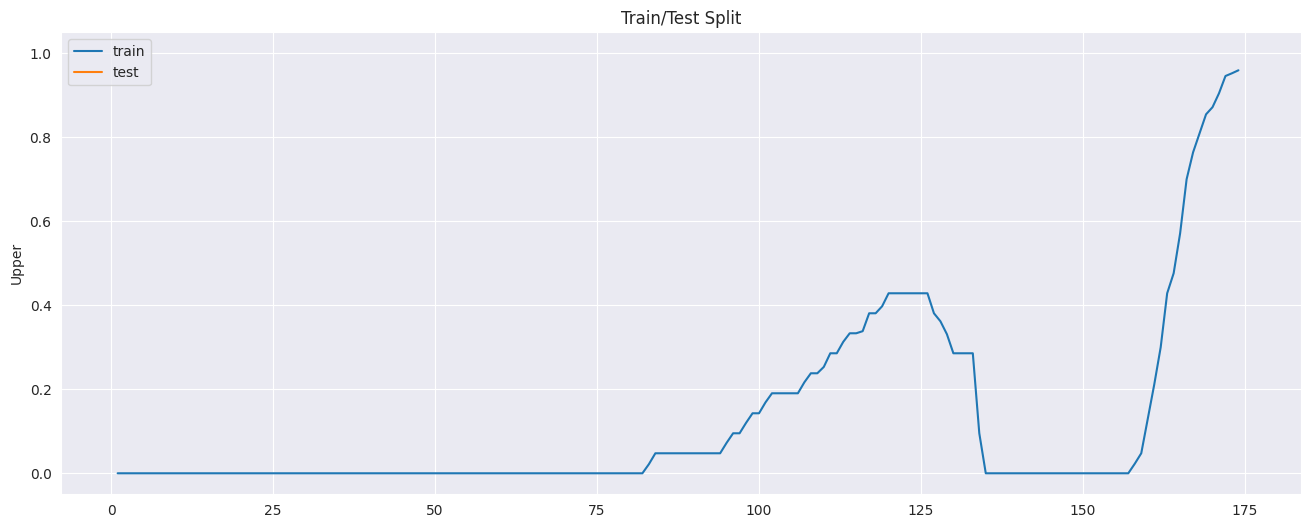

x_train: (174, 8) y_train: (174, 2) x_test: (1, 8) y_test: (1, 2)
x_train_past: (174, 4) x_train_future: (174, 2) x_test_past: (1, 4) x_test_future: (1, 2)
y_train: (174, 1, 2) y_test: (1, 1, 2)


In [57]:
plt.figure(figsize=(16, 6))
sns.lineplot(train['Upper'], label='train')
sns.lineplot(test['Upper'], label='test')
plt.title('Train/Test Split')
plt.legend()
plt.show()
x_train, y_train = train.drop(['Upper', 'Lower'], axis=1), train[['Upper', 'Lower']]
x_test, y_test = test.drop(['Upper', 'Lower'], axis=1), test[['Upper', 'Lower']]
print('x_train:', x_train.shape, 'y_train:', y_train.shape, 'x_test:', x_test.shape, 'y_test:', y_test.shape)
x_train_past = x_train.filter(regex='Lag')
x_train_future = x_train[['CPI', 'Regime']].to_numpy().astype(np.float32)
x_test_past = x_test.filter(regex='Lag')
x_test_future = x_test[['CPI', 'Regime']].to_numpy().astype(np.float32)
print('x_train_past:', x_train_past.shape, 'x_train_future:', x_train_future.shape, 'x_test_past:', x_test_past.shape, 'x_test_future:', x_test_future.shape)

x_train_past = x_train_past.to_numpy().reshape(-1, 15, 4)
y_train = y_train.to_numpy().reshape(-1, 1, 2)
x_test_past = x_test_past.to_numpy().reshape(-1, 15, 4)
y_test = y_test.to_numpy().reshape(-1, 1, 2)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

In [58]:
x_train.head()

,Year,Month,CPI,Regime,Upper Lag - 1,Lower Lag - 1,Regime Lag - 1,CPI Lag - 1
1,0.0,0.090909,0.582995,0.0,0.0,0.0,0.0,0.526700
2,0.0,0.181818,0.348580,0.0,0.0,0.0,0.0,0.582995
3,0.0,0.272727,0.449555,0.0,0.0,0.0,0.0,0.348580
4,0.0,0.363636,0.473068,0.0,0.0,0.0,0.0,0.449555
5,0.0,0.454545,0.818771,0.0,0.0,0.0,0.0,0.473068


In [59]:
x_train_future

array([[0.5829945 , 0.        ],
       [0.3485796 , 0.        ],
       [0.44955522, 0.        ],
       [0.47306758, 0.        ],
       [0.8187714 , 0.        ],
       [0.38347855, 0.        ],
       [0.5680993 , 0.        ],
       [0.49632683, 0.        ],
       [0.5505511 , 0.        ],
       [0.5681044 , 0.        ],
       [0.4249037 , 0.        ],
       [0.43140957, 0.        ],
       [0.35037693, 0.        ],
       [0.4153448 , 0.        ],
       [0.41021097, 0.        ],
       [0.37224892, 0.        ],
       [0.3773625 , 0.        ],
       [0.49320805, 0.        ],
       [0.47255623, 0.        ],
       [0.48034307, 0.        ],
       [0.57484823, 0.        ],
       [0.5268514 , 0.        ],
       [0.60192496, 0.        ],
       [0.5627579 , 0.        ],
       [0.56131494, 0.        ],
       [0.6604983 , 0.        ],
       [0.6362265 , 0.        ],
       [0.5596543 , 0.        ],
       [0.39856616, 0.        ],
       [0.53121567, 0.        ],
       [0.

## Defining the Model
Now let's define the model. We're going to use recurrent neural networks (RNNs) since they work very well with time-series data. We'll use long short-term memory (LSTM) layers since they're the most popular and are pretty accurate.

Although LSTM is supposed to mitigate the vanishing gradient problem, I found that it still occured (the model would predict a straight horizontal line). Thus, we added batch normalization layers to mitigate vanishing gradients further.

### Model Architecture
Since I want to use both past inflation/interest data AND future inflation data to predict future interest data, I can't use the Sequential model. Thus, we will have a model with 2 input layers. The one with LSTM layers will predict the next interest rate given previous interest rates. The other input layer will predict the next interest rate given future inflation data. The two outputs will be concatenated and fed into a few dense (we don't need LSTM anymore since this is no longer time-series data) layers to get the final prediction.

In [67]:
from keras.src.optimizers import Adam
from keras.src.layers import LSTM, Dense, Concatenate, BatchNormalization
from keras import Input, Model

input_past = Input(shape=x_train_past.shape[1:])
past_lstm = (
    BatchNormalization()(
    LSTM(64, return_sequences=False)(
    BatchNormalization()(
    LSTM(64, return_sequences=True)(
    BatchNormalization()(
    LSTM(64, return_sequences=True)(
    BatchNormalization()(
    LSTM(64, return_sequences=True)(input_past)))))))))
output_past = Dense(2)(past_lstm)
input_future = Input(shape=x_train_future.shape[1])
concat =  Concatenate()([output_past, input_future])
future_dense = (
    Dense(64, activation='relu')(
    Dense(64, activation='relu')(
    Dense(64, activation='relu')(concat))))
output = Dense(2)(future_dense)

model = Model(inputs=[input_past, input_future], outputs=output)
model.compile(optimizer=Adam(), loss='mse')
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1, 4)]               0         []                            
                                                                                                  
 lstm_15 (LSTM)              (None, 1, 128)               68096     ['input_9[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 1, 128)               512       ['lstm_15[0][0]']             
 tchNormalization)                                                                                
                                                                                                  
 lstm_14 (LSTM)              (None, 256)                  394240    ['batch_normalization_15

## Training the Model
Now let's train the model. After fitting, we'll graph the loss to see how well the model did.

Epoch 1/1000
6/6 [==============================] - 3s 15ms/step - loss: 0.0576
Epoch 2/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0526
Epoch 3/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0514
Epoch 4/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0511
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 6/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0503
Epoch 7/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0502
Epoch 8/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0512
Epoch 9/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0512
Epoch 10/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0530
Epoch 11/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0508
Epoch 12/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0505
Epoch 13/1000
6/6 [==================

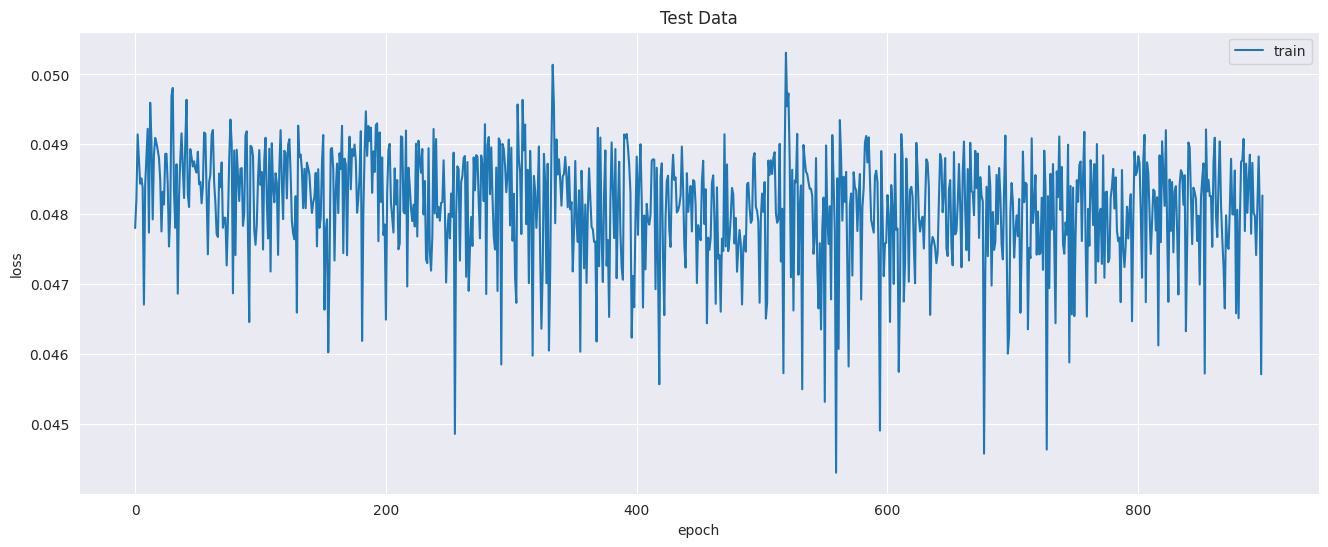

In [68]:
model.fit([x_train_past, x_train_future], y_train, epochs=1000, batch_size=32, verbose=1)

plt.figure(figsize=(16, 6))
plt.title('Test Data')
plt.plot(model.history.history['loss'][100:], label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

We'll also graph the actual and predicted values to see how close the model was. This is where we'll undo the normalization to get real-world values.
# Results
## Test Set Performance

1/1 [==============================] - 0s 21ms/step
0.11451092 0.13750124


/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

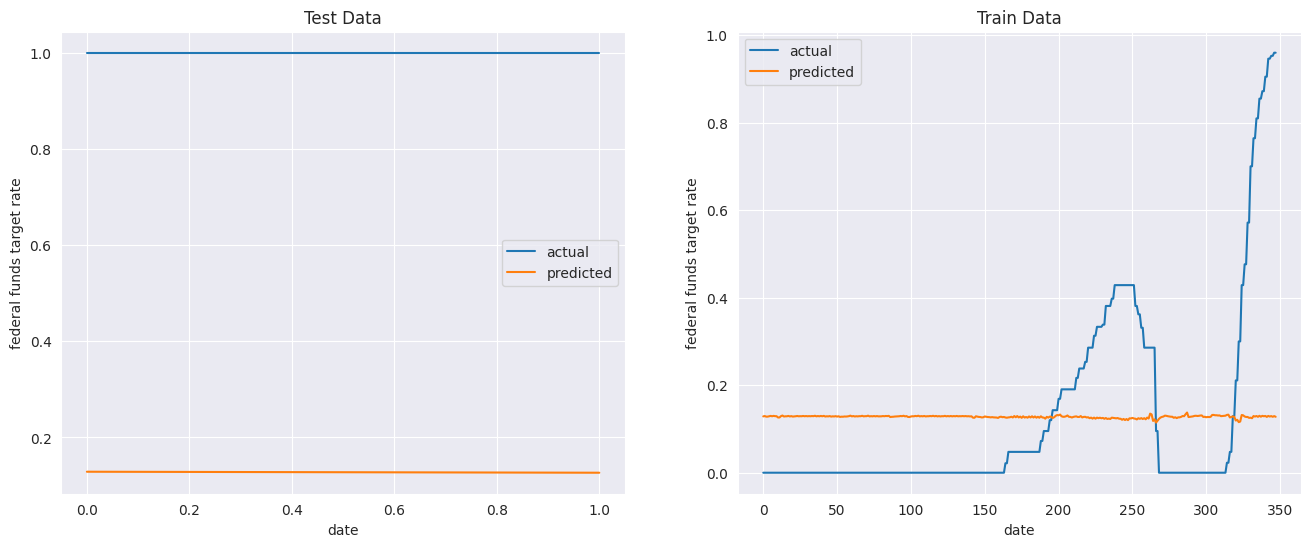

In [64]:
train_pred = model.predict([x_train_past, x_train_future]).flatten()
test_pred = model.predict([x_test_past, x_test_future]).flatten()

print(train_pred.min(), train_pred.max())

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Test Data')
sns.lineplot(y_test.flatten(), label='actual')
sns.lineplot(test_pred, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.subplot(122)
plt.title('Train Data')
sns.lineplot(y_train.flatten(), label='actual')
sns.lineplot(train_pred, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import r2_score

print('Train R2: ', r2_score(y_train.flatten(), train_pred.flatten()))
print('Test R2: ', r2_score(y_test.flatten(), test_pred.flatten()))

Train R2:  -0.007323045168158293
Test R2:  -6.175002873276282e+31
